In [55]:
import pandas as pd
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from matplotlib.lines import TICKLEFT, TICKRIGHT, Line2D
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.dates as mdate
from datetime import time
from typing import Iterable

class Kline(object):
    def DrawKline(self,aa,**para):
    #     date='2014-01-03'
        # aa=df1[str(date)]
        aa.reset_index(drop=True,inplace=True)
        fig =plt.figure(figsize=(45, 18),facecolor='w')

        #副图是主图的比例
        w1=0.25
        w2=0.8/(1+w1)*w1
        rec1=[0.1,0.1+w2,0.9,w2/w1]
        rec2=[0.1,0.1,0.9,w2]
        ax=fig.add_axes(rec1)
        ax1=fig.add_axes(rec2,sharex=ax)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax1.get_xticklabels(), visible=True)

        #设置时间刻度
        dlist=aa.datetime.apply(lambda x:str(x.time()))
        dd=dlist.values
        d1=[i*100 for i in range(len(dd))]
        ax1.set_xticks(d1[::30])
        ax1.set_xticklabels(dd[::30])

        Kline={}
        Kline['W'] = 80
        Kline['Diff'] = 20
        Kline['WW']=100
        
        if 'rec' in para.keys():
            id1=para['rec'][0]
            id2=para['rec'][1]
            y1=aa[id1:id2]['close'].max()
            y2=aa[id1:id2]['close'].min()
            a1 =(id1+1)*Kline['WW']
            a2 =(id2+1)*Kline['WW']
            ax.axvline(a1,ymax=1,c= "b",ls = "--",linewidth=1)    
            ax.axvline(a2,ymax=1,c= "b",ls = "--",linewidth=1)
            ax.axhline(y1,xmax=1,c= "b",ls = "--",linewidth=1)
            ax.axhline(y2,xmax=1,c= "b",ls = "--",linewidth=1)
        
        if 'buy' in para.keys():
            buy=para['buy']
            if not isinstance(buy, Iterable):
                buy = [buy]
            for pos in buy:
                x =(pos+1)*Kline['WW']
                y=aa.iloc[pos]['low']-5
                ax.plot(x,y,'r^')
        
        if 'sell' in para.keys():
            sell=para['sell']
            if not isinstance(sell, Iterable):
                sell = [sell]
            for pos in sell:
                x =(pos+1)*Kline['WW']
                y=aa.iloc[pos]['high']+5
                ax.plot(x,y,'gv')
        
        if 'trade' in para.keys():
            trade=para['trade']
            if trade[0]==1:
                x1 =(trade[1]+1)*Kline['WW']
                y1=aa.iloc[trade[1]]['low']-5
                x2 =(trade[2]+1)*Kline['WW']
                y2 =aa.iloc[trade[2]]['high']+5
                ax.plot(x1,y1,'r^')
                ax.plot(x2,y2,'gv')
                y3=aa.iloc[trade[1]]['close']
                y4=aa.iloc[trade[2]]['close']
                ax.plot([x1,x2],[y3,y4],c='m',ls='--',linewidth=2)
                txt="Buy Diff:%s" %(y4-y3)
                ax.text(x2,y2+10,txt,fontsize=14,color='r')
            elif trade[0]==2:
                x1 =(trade[1]+1)*Kline['WW']
                y1=aa.iloc[trade[1]]['high']+5
                x2 =(trade[2]+1)*Kline['WW']
                y2 =aa.iloc[trade[2]]['low']-5
                ax.plot(x1,y1,'gv')
                ax.plot(x2,y2,'r^')
                y3=aa.iloc[trade[1]]['close']
                y4=aa.iloc[trade[2]]['close']
                ax.plot([x1,x2],[y3,y4],c='g',ls='--',linewidth=2)
                txt="Sell Diff:%s" %(y3-y4)
                y2 =aa.iloc[trade[2]]['high']+10
                ax.text(x2,y2,txt,fontsize=14,color='r')
        d=0
        rows=len(aa)
        for i in aa.iterrows():
            Row=i[1]
            x1 =(d+1)*Kline['WW']
            x2 = x1-Kline['W']/2
            O = Row['open']
            C = Row['close']
            L = Row['low']
            H = Row['high']
            hh = abs(C - O)

            if C > O:
                a = False
                y = O
                cc = 'R'
                # 上影线 下影线
                line1 = Line2D((x1, x1), (C, H), color=cc)
                line2 = Line2D((x1, x1), (O, L), color=cc)

                ax.add_line(line1)
                ax.add_line(line2)
            else:
                a = True
                y = C
                cc = 'C'
                # 影线
                line = Line2D((x1, x1), (L, H), color=cc)
                ax.add_line(line)
            hh = abs(C - O)

            # K线实体
            rec = Rectangle((x2, y), Kline['W'], hh, fill=a, color=cc)
            ax.add_patch(rec)

            if Row['macd']>0:
                rec= Rectangle((x2, 0), Kline['W'], Row['macd'], fill=a, color='R')
            else:
                rec= Rectangle((x2, 0), Kline['W'], Row['macd'], fill=a, color='C')
            ax1.add_patch(rec)
            d+=1
            
        if any(["ma60" in aa.columns,"MA60" in aa.columns]):
            ax.plot(aa.index*Kline['WW']+Kline['WW'],aa['ma60'],c='r')
        if any(["ma30" in aa.columns,"MA30" in aa.columns]):
            ax.plot(aa.index*Kline['WW']+Kline['WW'],aa['ma30'],c='b')
        ax1.axhline(0,linestyle="--",linewidth=0.5,color='k')
        if "diff" in aa.columns:
            ax1.plot(aa.index*Kline['WW']+Kline['WW'],aa['diff'],c='b',linewidth=0.5)
        if "dea" in aa.columns:
            ax1.plot(aa.index*Kline['WW']+Kline['WW'],aa['dea'],c='y',linewidth=0.5)

        ax.grid()
        ax1.grid()
        ax.autoscale(tight=False)
        ax.autoscale_view()

        time1=aa.iloc[0]['datetime']
        time2=aa.iloc[-1]['datetime']
        title="%s--%s" %(time1,time2)
        ax.set_title(title, fontsize=20, color='r')
        
        if "save" in para.keys():
            file=para['save']
            fig.savefig(file)
            print(file)
        else:
            plt.show()
        fig.clear()
        plt.close(fig)

print("OK")


OK


In [ ]:
from typing import Iterable

In [57]:
aa=pd.read_pickle("pkl/HSI1903")
bb=aa[aa.trade_date=='2019-03-26']

In [43]:
def abc(*a,**b):
    print(a)
    print(b)

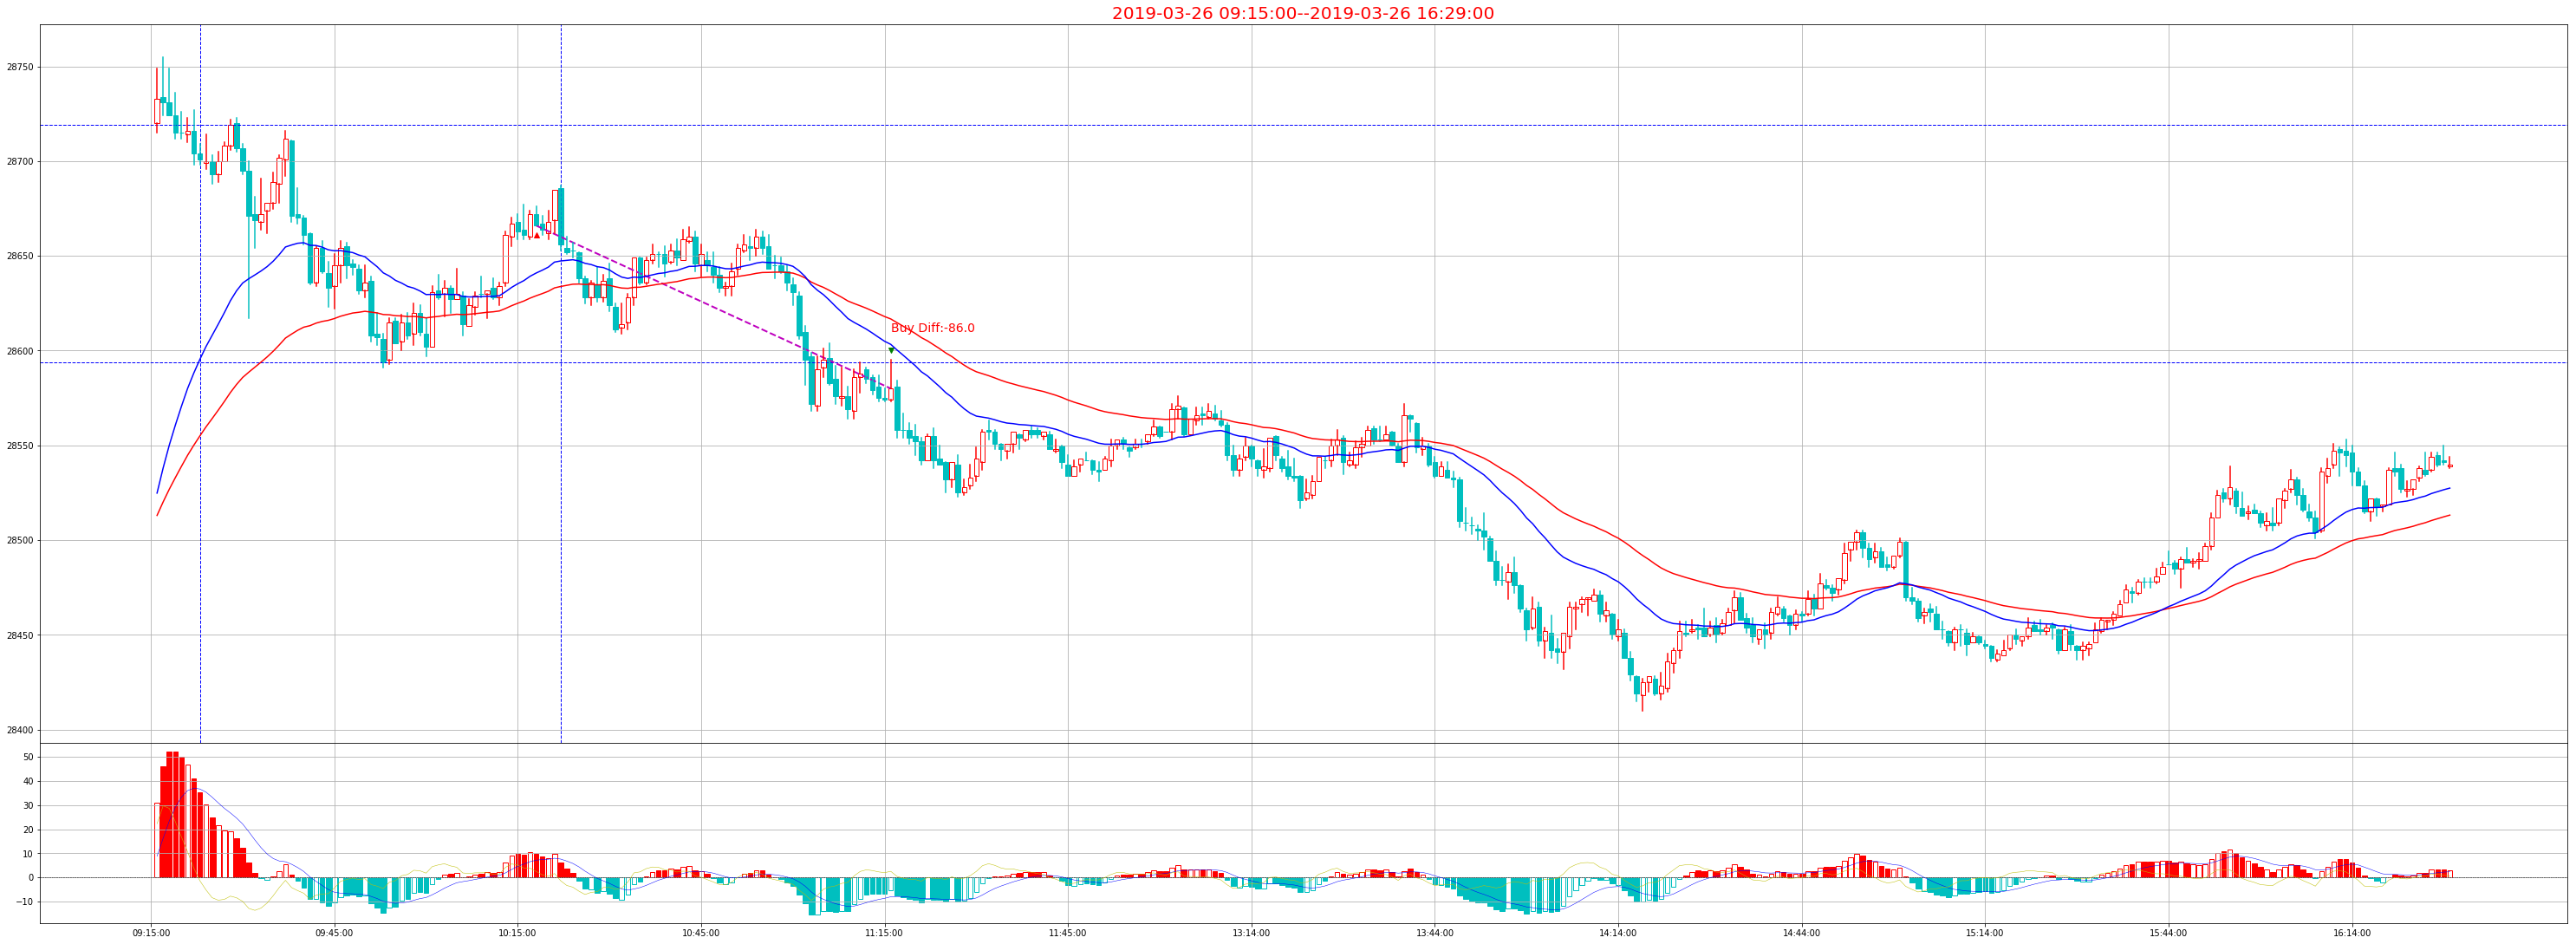

In [59]:
kk=Kline()
kk.DrawKline(bb,rec=[7,66],trade=(1,62,120))